## Step 0. Read in Data and NLTK Basics

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [72]:
df = pd.read_csv("Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Quick EDA

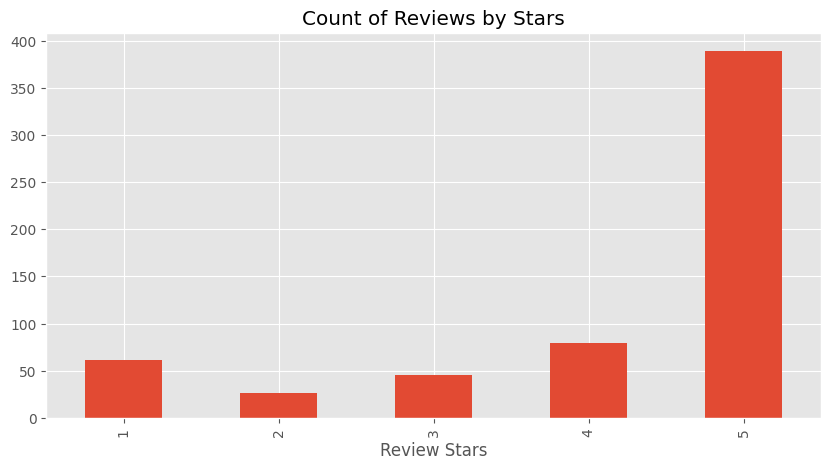

In [112]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [74]:
example = df['Text'][20]
print(example)

My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.


In [75]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [76]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['My', 'husband', 'is', 'a', 'Twizzlers', 'addict', '.', 'We', "'ve", 'bought']

In [77]:
nltk.download('averaged_perceptron_tagger_eng')

tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


[('My', 'PRP$'),
 ('husband', 'NN'),
 ('is', 'VBZ'),
 ('a', 'DT'),
 ('Twizzlers', 'NNP'),
 ('addict', 'NN'),
 ('.', '.'),
 ('We', 'PRP'),
 ("'ve", 'VBP'),
 ('bought', 'VBN')]

In [78]:
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


(S
  My/PRP$
  husband/NN
  is/VBZ
  a/DT
  Twizzlers/NNP
  addict/NN
  ./.
  We/PRP
  've/VBP
  bought/VBN
  these/DT
  many/JJ
  times/NNS
  from/IN
  (GPE Amazon/NNP)
  because/IN
  we/PRP
  're/VBP
  government/NN
  employees/NNS
  living/VBG
  overseas/RB
  and/CC
  ca/MD
  n't/RB
  get/VB
  them/PRP
  in/IN
  the/DT
  country/NN
  we/PRP
  are/VBP
  assigned/VBN
  to/TO
  ./.
  They/PRP
  've/VBP
  always/RB
  been/VBN
  fresh/JJ
  and/CC
  tasty/JJ
  ,/,
  packed/VBN
  well/RB
  and/CC
  arrive/JJ
  in/IN
  a/DT
  timely/JJ
  manner/NN
  ./.)


# Step 1. VADER Seniment Scoring

We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.


In [79]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

senti = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [80]:
senti.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [81]:
senti.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [82]:
senti.polarity_scores(example)

{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6249}

In [83]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    if isinstance(text, str):
        res[myid] = senti.polarity_scores(text)
    else:
        print(f"Warning: Skipping review with Id {myid} due to invalid text format.")

  0%|          | 0/600 [00:00<?, ?it/s]

In [84]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [85]:
vaders.head()    # sentiment result and dataframe

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Plot VADER results

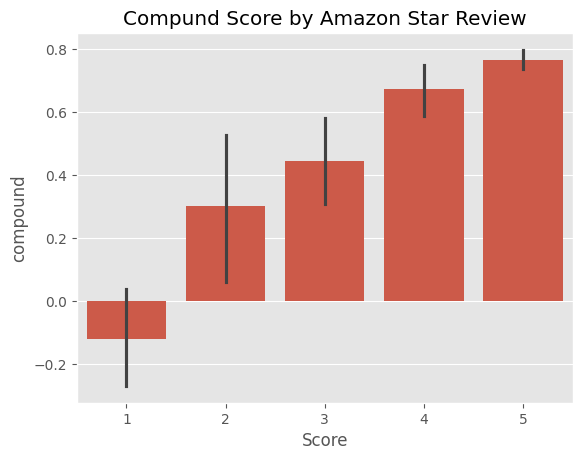

In [86]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

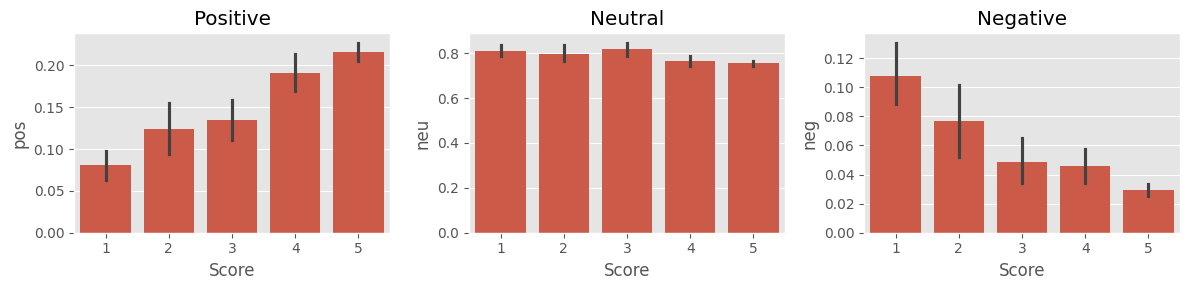

In [87]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Robustly Optimized BERT Approach
- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [88]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [89]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [90]:
# VADER results on example
print(example)
senti.polarity_scores(example)

My husband is a Twizzlers addict.  We've bought these many times from Amazon because we're government employees living overseas and can't get them in the country we are assigned to.  They've always been fresh and tasty, packed well and arrive in a timely manner.


{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'compound': 0.6249}

In [91]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': np.float32(0.010422163), 'roberta_neu': np.float32(0.065259255), 'roberta_pos': np.float32(0.9243186)}


In [92]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [93]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = senti.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/600 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540


In [94]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

## Compare Scores between models

In [95]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

# Step 3. Combine and compare

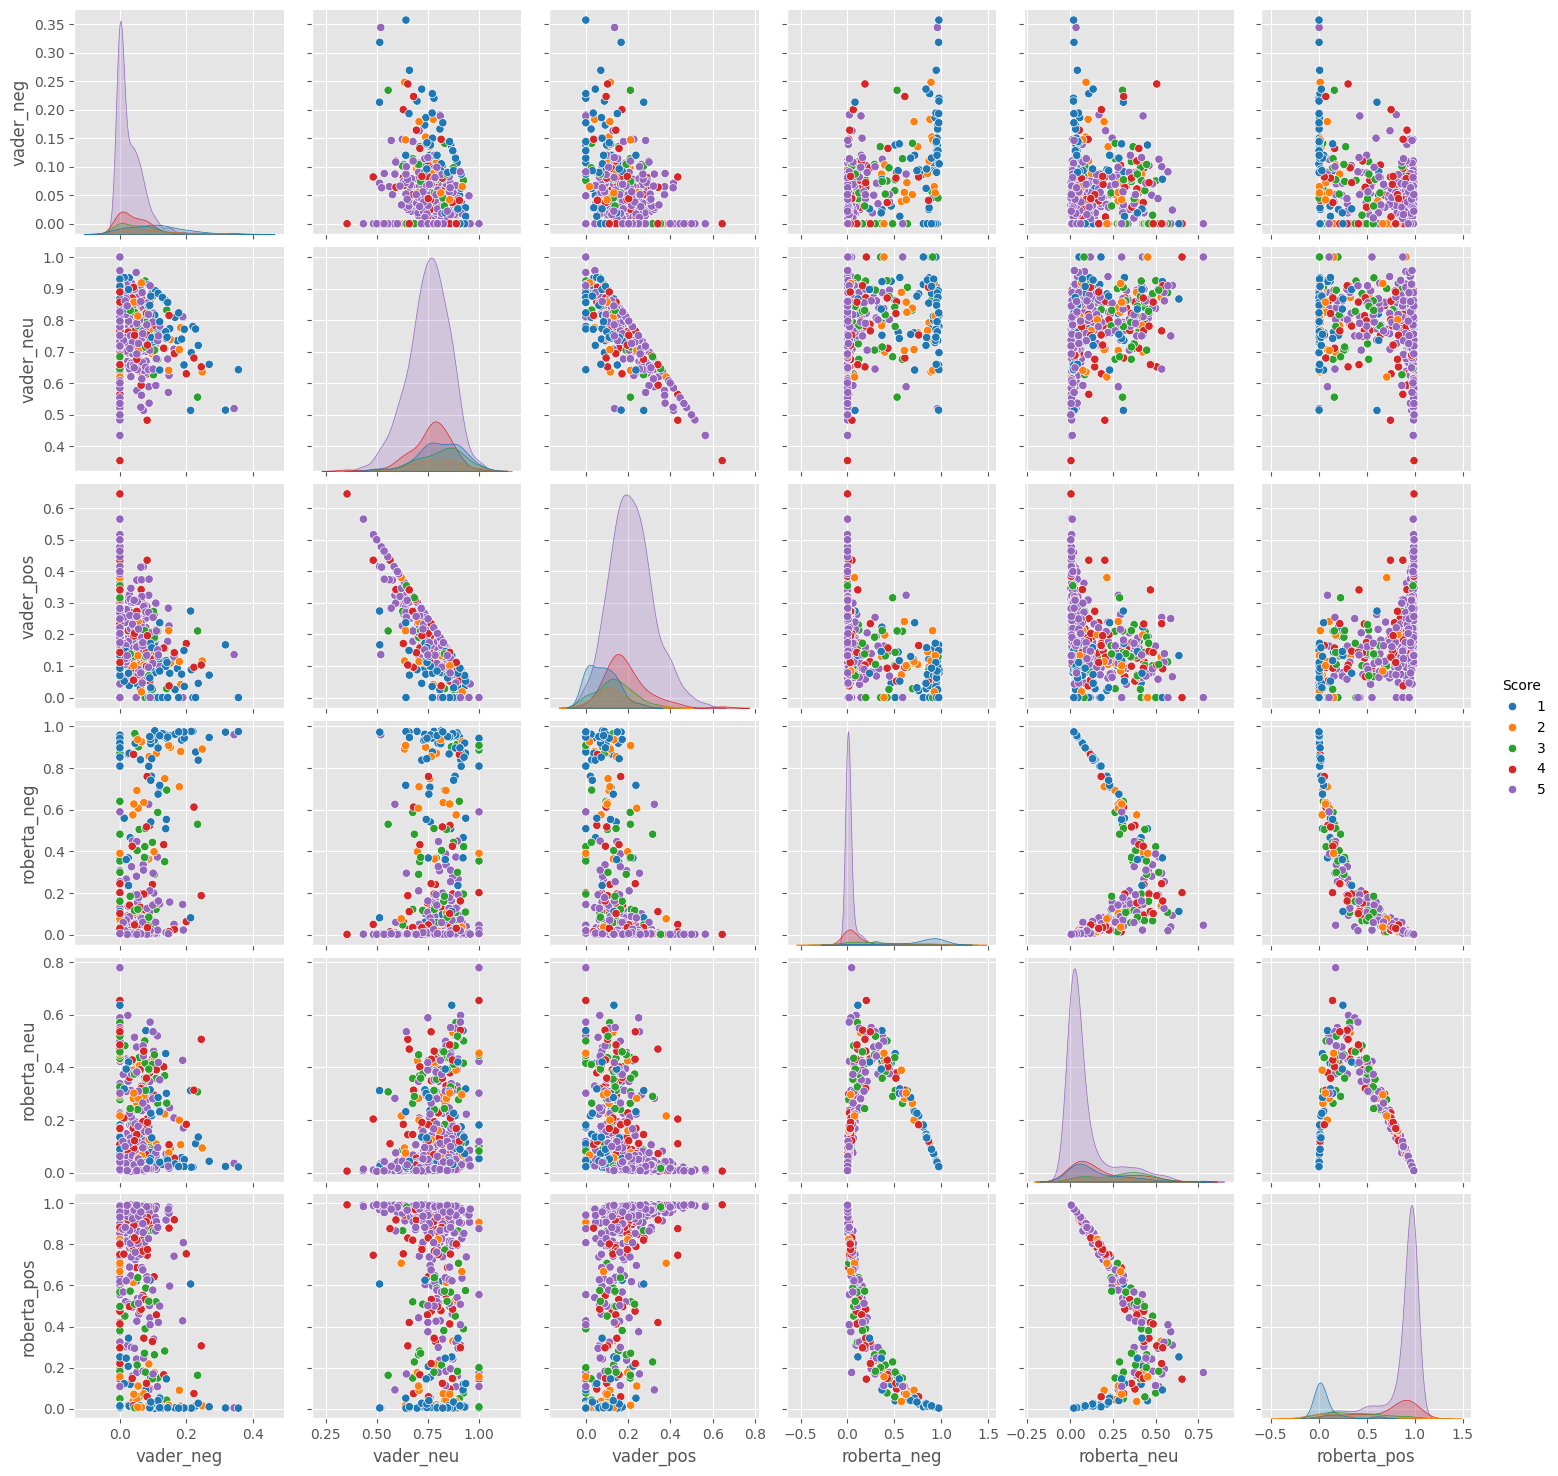

In [96]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

# Step 4: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [97]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [98]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [ ]:
# nevative sentiment 5-Star view

In [99]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [100]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [101]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [102]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Save the model and tokenizer
model.save_pretrained("./saved_model")
tokenizer.save_pretrained("./saved_model")

('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.json',
 './saved_model/merges.txt',
 './saved_model/added_tokens.json',
 './saved_model/tokenizer.json')

In [103]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "./saved_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [104]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [105]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [106]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

# The End

In [110]:
%%writefile app.py
import streamlit as st
from transformers import pipeline

def main():
    st.title("Sentiment Analysis App")
    st.write("Enter your review below, and the model will predict the sentiment.")

    user_input = st.text_area("Enter your feedback:", "")

    sentiment_pipeline = pipeline("sentiment-analysis")

    if st.button("Predict"):
        if user_input:
            result = sentiment_pipeline(user_input)
            sentiment = result[0]['label']
            score = result[0]['score']

            st.subheader("Sentiment Prediction")
            st.write(f"**Sentiment:** {sentiment}")
            st.write(f"**Confidence Score:** {score:.2f}")

            if sentiment == "POSITIVE":
                st.success("This is a Positive Review! 😊")
            elif sentiment == "NEGATIVE":
                st.error("This is a Negative Review! 😞")
            else:
                st.warning("This is a Neutral Review! 😐")
        else:
            st.warning("Please enter text before clicking Predict.")

if __name__ == "__main__":
    main()

Overwriting app.py


In [113]:
from sklearn.metrics import classification_report, accuracy_score

# Convert review scores (1-5 stars) into sentiment labels
def convert_star_to_sentiment(score):
    if score >= 4:
        return 1  # Positive
    elif score == 3:
        return 2  # Neutral
    else:
        return 0  # Negative

# Apply conversion
results_df['true_sentiment'] = results_df['Score'].apply(convert_star_to_sentiment)

# Convert VADER sentiment scores into labels
results_df['vader_pred'] = results_df['vader_compound'].apply(lambda x: 1 if x >= 0.05 else (0 if x <= -0.05 else 2))

# Convert RoBERTa sentiment scores into labels
def roberta_label(row):
    if row['roberta_pos'] > row['roberta_neg'] and row['roberta_pos'] > row['roberta_neu']:
        return 1  # Positive
    elif row['roberta_neg'] > row['roberta_pos'] and row['roberta_neg'] > row['roberta_neu']:
        return 0  # Negative
    else:
        return 2  # Neutral

results_df['roberta_pred'] = results_df.apply(roberta_label, axis=1)

# Compute metrics for VADER
print("VADER Sentiment Analysis Performance:")
print(classification_report(results_df['true_sentiment'], results_df['vader_pred']))
print("VADER Accuracy:", accuracy_score(results_df['true_sentiment'], results_df['vader_pred']))

# Compute metrics for RoBERTa
print("\nRoBERTa Sentiment Analysis Performance:")
print(classification_report(results_df['true_sentiment'], results_df['roberta_pred']))
print("RoBERTa Accuracy:", accuracy_score(results_df['true_sentiment'], results_df['roberta_pred']))

VADER Sentiment Analysis Performance:
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        86
           1       0.86      0.95      0.90       465
           2       0.26      0.11      0.16        45

    accuracy                           0.81       596
   macro avg       0.58      0.50      0.53       596
weighted avg       0.78      0.81      0.79       596

VADER Accuracy: 0.8120805369127517

RoBERTa Sentiment Analysis Performance:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74        86
           1       0.94      0.92      0.93       465
           2       0.22      0.22      0.22        45

    accuracy                           0.85       596
   macro avg       0.62      0.64      0.63       596
weighted avg       0.85      0.85      0.85       596

RoBERTa Accuracy: 0.8473154362416108


In [111]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

import joblib
joblib.dump(sent_pipeline, "sentiment_pipeline.pkl")

# Load it back later
sent_pipeline = joblib.load("sentiment_pipeline.pkl")


Device set to use cpu
